In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [3]:
X_train, Y_train, X_test, Y_test = torch.load('./data/dataset_1_40D.pt')

# 将数据移动到适当的设备
X_train = X_train.to(device)
Y_train = Y_train.to(device)
X_test = X_test.to(device)
Y_test = Y_test.to(device)

X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

(torch.Size([8000, 41]),
 torch.Size([8000]),
 torch.Size([2000, 41]),
 torch.Size([2000]))

In [4]:
# 使用 DataLoader 进行批处理
l = 64
train_dataset = TensorDataset(X_train, Y_train)
train_loader = DataLoader(train_dataset, batch_size=l, shuffle=True)

# 打印第一个批次的大小
for x, y in train_loader:
    print(x.shape, y.shape)
    break

torch.Size([64, 41]) torch.Size([64])


In [5]:
D = 40
m = 1000

In [6]:
class PM_Euler(nn.Module):
    def __init__(self, input, hidden_layer, output):
        super(PM_Euler, self).__init__()
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(input, hidden_layer)
        self.fc2 = nn.Linear(hidden_layer, output)
        self.hidden_dim = hidden_layer
        # He initialization
        nn.init.kaiming_normal_(self.fc1.weight)
        nn.init.kaiming_normal_(self.fc2.weight)
        
    def forward(self, x):
        z1 = self.fc1(x)
        z2 = self.relu(z1)
        f1 = self.fc2(z2) / self.hidden_dim
        return f1
    
model = PM_Euler(D + 1, m, 1).to(device)

model(X_train).shape ,Y_train.reshape((-1, 1)).shape

(torch.Size([8000, 1]), torch.Size([8000, 1]))

In [7]:
epochs = 10000
lr = 0.2

train_losses = []
test_losses = []

criterion = nn.MSELoss(reduction='mean')
optimizer = optim.SGD(model.parameters(), lr=lr)

for epoch in range(epochs):
    model.train()
    for x, y in train_loader:
        optimizer.zero_grad()
        y_pred = model(x)
        loss = criterion(y_pred, y.reshape(y_pred.shape))
        loss.backward()
        optimizer.step()
    
    model.eval()
    with torch.no_grad():
        y_pred_train = model(X_train)
        y_pred_test = model(X_test)
        train_loss = criterion(y_pred_train, Y_train.reshape(y_pred_train.shape))
        test_loss = criterion(y_pred_test, Y_test.reshape(y_pred_test.shape))
    train_losses.append(train_loss.item())
    test_losses.append(test_loss.item())
    print(f'Epoch {epoch}, Train Loss: {train_loss}, Test Loss: {test_loss}')

Epoch 0, Train Loss: 0.9969203472137451, Test Loss: 1.0109018087387085
Epoch 1, Train Loss: 0.9967473745346069, Test Loss: 1.0107187032699585
Epoch 2, Train Loss: 0.9965744018554688, Test Loss: 1.0105355978012085
Epoch 3, Train Loss: 0.9964014291763306, Test Loss: 1.0103524923324585
Epoch 4, Train Loss: 0.9962283372879028, Test Loss: 1.0101690292358398
Epoch 5, Train Loss: 0.9960551261901855, Test Loss: 1.0099854469299316
Epoch 6, Train Loss: 0.9958816766738892, Test Loss: 1.0098015069961548
Epoch 7, Train Loss: 0.9957079291343689, Test Loss: 1.0096172094345093
Epoch 8, Train Loss: 0.9955338835716248, Test Loss: 1.0094321966171265
Epoch 9, Train Loss: 0.9953592419624329, Test Loss: 1.009246826171875
Epoch 10, Train Loss: 0.9951841235160828, Test Loss: 1.0090607404708862
Epoch 11, Train Loss: 0.9950084090232849, Test Loss: 1.0088740587234497
Epoch 12, Train Loss: 0.9948320984840393, Test Loss: 1.0086865425109863
Epoch 13, Train Loss: 0.9946549534797668, Test Loss: 1.008498191833496
Epoc

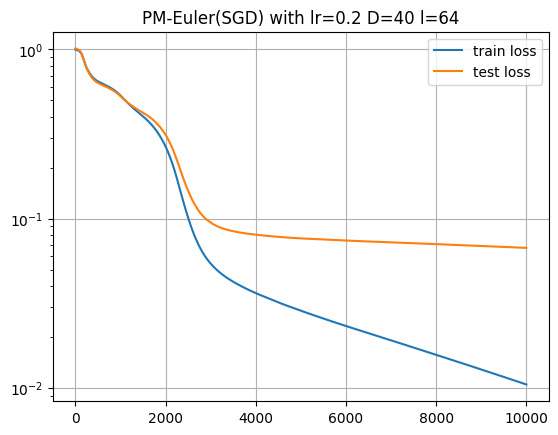

In [8]:
# 绘制训练和测试损失
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.yscale('log')
plt.legend()
plt.grid()
plt.title('PM-Euler(SGD) with lr=0.2 D=40 l=64')
plt.show()